In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
CaseName_Base = 'IEEE118_mod1'

Folder_A = 'A.The_full_year_MILP'
Folder_B = 'B.Operation_cost'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_K = 'K.Investments_per_hour'
Folder_L = 'L.Cont_Investments_per_hour'

Folder_JB = 'J.Full_year_operational_cost\\Results\\B.'
Folder_JD = 'J.Full_year_operational_cost\\Results\\D.'
Folder_JE = 'J.Full_year_operational_cost\\Results\\E.'
Folder_JK = 'J.Full_year_operational_cost\\Results\\K.'
Folder_JL = 'J.Full_year_operational_cost\\Results\\L.'

Folder_JB = 'J.Full_year_operational_cost\\Results\\B.Operation_cost'
Folder_JD = 'J.Full_year_operational_cost\\Results\\D.Representative_days_based_on_RES_and_Demand'
Folder_JE = 'J.Full_year_operational_cost\\Results\\E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_JK = 'J.Full_year_operational_cost\\Results\\K.Investments_per_hour'
Folder_JL = 'J.Full_year_operational_cost\\Results\\L.Cont_Investments_per_hour'

DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
category_dict = {Folder_A: "FYMILP",
                 Folder_B: "OPC",
                 Folder_D: "R&D",
                 Folder_E: "OPT_LB",
                 Folder_K: "Hourly_inv",
                 Folder_L: "CHI",
                 Folder_JB: "OPC_fy",
                 Folder_JD: "R&D_fy",
                 Folder_JE: "OPT_LB_fy",
                 Folder_JK: "HI_fy",
                 Folder_JL: "CHI_fy"
                }

In [9]:
def LoadingData(dir, folder,result, case, ncluster, cm):
    #If the folder is A, the name is slightly different (no ByStages in the name and not dependent on nb clust)
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, '3.Out', f'oT_Result_{result}_'+case+'.csv'), index_col=[0,1])
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '3.Out', f'oT_Result_{result}_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'), index_col=[0,1])

    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
    df['Number of clusters'] = ncluster
    df = df.reset_index()

    return df

#Load the weights of the representative periods 
def LoadingWeights(dir, folder, case, ncluster):
    if folder == 'A.The_full_year_MILP': 
        df_stage = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Stage_'+case+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Duration_'+case+'.csv'))
    else: 
        df_stage = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Stage_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Duration_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
    durations_filtered = df_duration[df_duration['Duration'] == 1]
    merged_df = pd.merge(df_stage, durations_filtered, left_on='Unnamed: 0', right_on='Stage', how='left')

    return merged_df


def get_overall_avg_utilization(df_utilization): 
    return df_utilization["GWh"].mean()

def get_weighted_overall_avg_Utilization(df_util,df_weights):
    merged_df = df_util.merge(df_weights,how = "left",on = "LoadLevel")
    merged_df["GWh_weighted"] = merged_df["GWh"] * merged_df["Weight"]
    return merged_df["GWh_weighted"].sum()/merged_df["Weight"].sum()

In [10]:
nbs_clusters = [(i+1)*10 for i in range(10)] + [150, 200, 250, 300,350, 400]
nbs_clusters = [(i+1)*10 for i in range(2)]

#folders = [Folder_JB, Folder_JD,Folder_JE,Folder_JL]#,Folder_E,Folder_F,Folder_G]
folders = [Folder_A,Folder_B,Folder_D,Folder_E,Folder_L,Folder_K]
#folders = [Folder_A,Folder_L,Folder_JL,Folder_D,Folder_JD,Folder_B,Folder_JB,Folder_E,Folder_JE]
results = ["NetworkUtilizationPerNode_DC"]

results_dfs = dict()
weights_dfs = dict()
results_w_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    weights_dfs[result] = dict()
    results_w_dfs[result] = dict()
    for folder in folders: 
        results_dfs[result][folder] = dict()
        results_w_dfs[result][folder] = dict()
        weights_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            try: 
                results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])
                if not(folder.startswith("J")):
                    weights_dfs[result][folder][nb_clusters] = LoadingWeights(DirName,folder,CaseName_Base,nb_clusters)
                    results_w_dfs[result][folder][nb_clusters] = results_dfs[result][folder][nb_clusters].merge(weights_dfs[result][folder][nb_clusters][["LoadLevel","Weight"]],on= "LoadLevel")
                                        
            except FileNotFoundError as e : 
                print(e)
                print(folder,nb_clusters, "Does not contain", result)

In [11]:
# Initialize DataFrames to store results
overal_avg_utilization = pd.DataFrame()
all_utils = pd.DataFrame()
i = 0

# Loop through each folder and number of clusters
for folder in folders:
    print(folder)
    for nb_clusters in nbs_clusters:
        # Calculate the overall average utilization
        overall_avg_util = get_overall_avg_utilization(results_dfs[result][folder][nb_clusters])
        
        # Calculate the weighted overall average utilization if necessary
        if folder.startswith("J."):
            overall_weighted_utilization = overall_avg_util
        else:
            overall_weighted_utilization = get_weighted_overall_avg_Utilization(
                results_dfs[result][folder][nb_clusters],
                weights_dfs[result][folder][nb_clusters]
            )
        
        # Create a new row with the calculated values
        row = pd.DataFrame({
            "Clustering method": category_dict[folder],
            "Number of clusters": nb_clusters,
            "Avg_util": overall_avg_util,
            "Avg_util_w": overall_weighted_utilization
        }, index=[i])
        i += 1
        
        # Concatenate the new row to the overall summary DataFrame
        overal_avg_utilization = pd.concat([overal_avg_utilization, row])
        
        # Concatenate the individual results to the all_utils DataFrame
        #all_utils = pd.concat([all_utils, results_dfs[result][folder][nb_clusters]])
        all_utils = pd.concat([all_utils, results_w_dfs[result][folder][nb_clusters]])

# Set the index of the overall summary DataFrame
overal_avg_utilization.set_index("Clustering method", inplace=True)


A.The_full_year_MILP
B.Operation_cost
D.Representative_days_based_on_RES_and_Demand
E.Representative_days_based_on_Line_Benefits_OptModel
L.Cont_Investments_per_hour
K.Investments_per_hour


In [77]:
all_utils_repeated_by_weight = all_utils.loc[all_utils.index.repeat(all_utils['Weight'])].reset_index(drop=True)

In [49]:
selected_nbs = [20]#,100,200]
selected_cms = ["FYMILP","R&D_fy","CHI_fy","OPT_LB_fy"]
selected_cms = ["FYMILP","OPC","R&D","CHI","OPT_LB"]
filter_ = all_utils["Number of clusters"].isin(selected_nbs) &  all_utils["Clustering method"].isin(selected_cms)
filter_repeated = all_utils_repeated_by_weight["Number of clusters"].isin(selected_nbs) &  all_utils_repeated_by_weight["Clustering method"].isin(selected_cms)

<Axes: xlabel='Number of clusters', ylabel='GWh'>

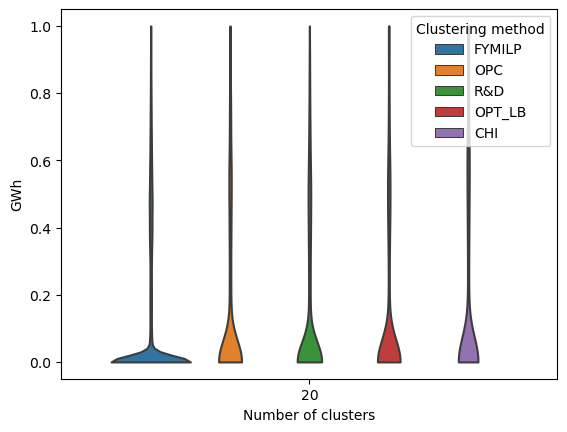

In [50]:
all_utils_sel = all_utils[filter_]
sns.violinplot(data = all_utils_sel,x = "Number of clusters",y = "GWh",hue = "Clustering method",inner=None,cut = 0,bw_method = "scott")

<Axes: xlabel='Number of clusters', ylabel='GWh'>

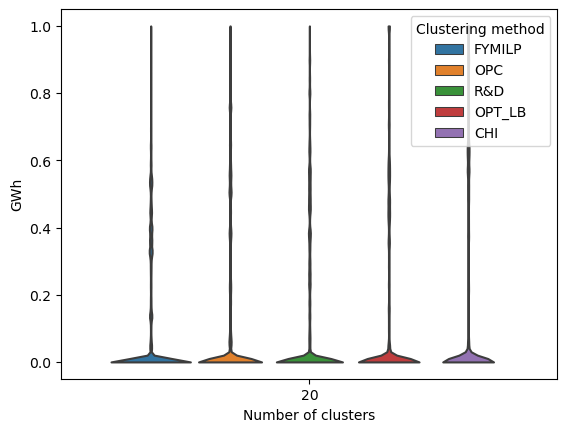

In [51]:
all_utils_sel = all_utils_repeated_by_weight[filter_repeated]
sns.violinplot(data = all_utils_sel,x = "Number of clusters",y = "GWh",hue = "Clustering method",inner=None,cut = 0)

<Axes: xlabel='Number of clusters', ylabel='GWh'>

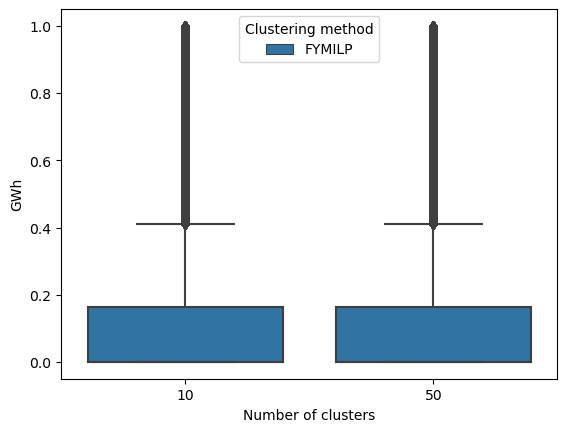

In [101]:
sns.boxplot(data = all_utils_sel,x = "Number of clusters",y = "GWh",hue = "Clustering method")

<Axes: xlabel='Number of clusters', ylabel='Avg_util_w'>

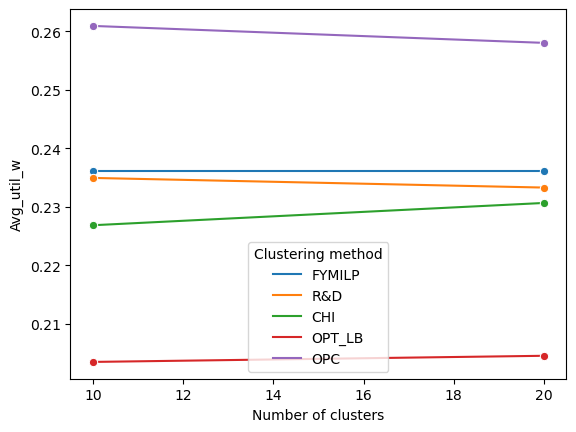

In [12]:
#Regular line plots
y = "Avg_util_w"
x = "Number of clusters"
#rf = overal_avg_utilization.loc[["FYMILP","R&D_fy","CHI_fy","OPT_LB_fy","OPC_fy"]]
rf = overal_avg_utilization.loc[["FYMILP","R&D","CHI","OPT_LB","OPC"]]
#rf = agg_results
sns.lineplot(data = rf,x = x, y = y,hue = "Clustering method",marker = "o")

<Axes: xlabel='Density', ylabel='GWh'>

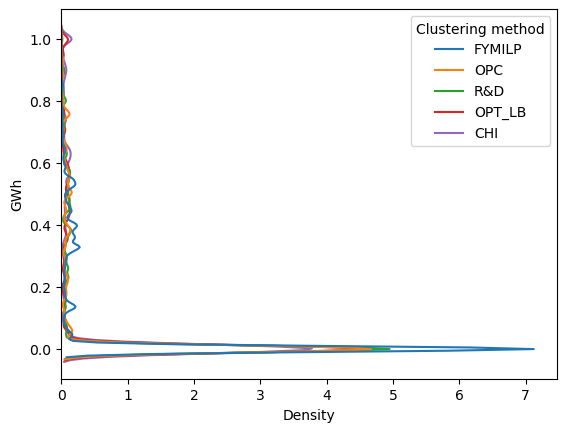

In [54]:
all_utils_sel = all_utils_repeated_by_weight[filter_repeated]
sns.kdeplot(data = all_utils_sel,y = "GWh",hue = "Clustering method")

In [56]:
selected_nbs = [20]#,100,200]
selected_cms = ["OPC","R&D","CHI","OPT_LB"]
filter_ = all_utils["Number of clusters"].isin(selected_nbs) &  all_utils["Clustering method"].isin(selected_cms)
filter_repeated = all_utils_repeated_by_weight["Number of clusters"].isin(selected_nbs) &  all_utils_repeated_by_weight["Clustering method"].isin(selected_cms)

<Axes: xlabel='GWh', ylabel='Density'>

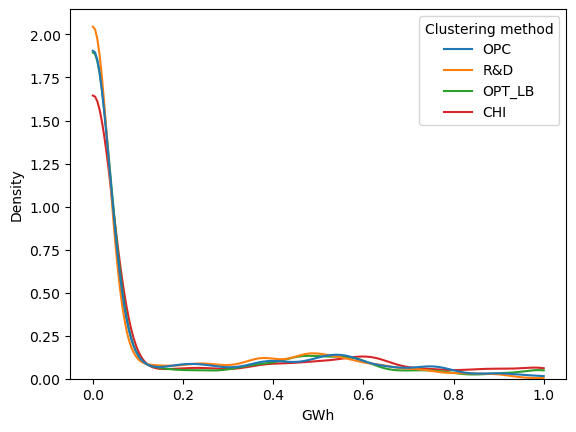

In [70]:
all_utils_sel = all_utils[filter_]
sns.kdeplot(data = all_utils_sel,x = "GWh",hue = "Clustering method",bw_method=0.15,cut = 0)